#### GISC 420 T1 2022
# **LAB ASSIGNMENT 1**
Corvin Idler,  ID 300598312

# Assignment part containig given code

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas
import pygeos

Defining get_hexgrid_size_and_extent()

In [4]:
import shapely # needed for geometry manipulations to make the hexes GeoSeries

# Returns a suitable grid dimension and extent for hexbinning
# based on an input points GeoDataframe. nx specifies the
# desired number of hexagons in the x direction. A one hex
# wide 'buffer' is included.
def get_hexgridsize_and_extent(pts, nx=15):
    # we need this later
    sqrt3 = 3 ** 0.5
    
    # see https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html
    x_min, y_min, x_max, y_max = pts.total_bounds
    x_range = x_max - x_min
    y_range = y_max - y_min

    # use this information to give us a little more room - a buffer
    x_buffer = x_range / (nx * 2)
    y_buffer = x_buffer * sqrt3 # y needs more because hexes are taller than they are wide
    x_min = x_min - x_buffer
    x_max = x_max + x_buffer
    y_min = y_min - y_buffer
    y_max = y_max + y_buffer
    
    # the hexbin function needs a grid and extent
    grid_dimensions = (nx, int(nx * y_range / x_range / sqrt3))
    pt_extent = (x_min, x_max, y_min, y_max)
    
    return grid_dimensions, pt_extent

Defining get_x_and_y()

In [5]:
# Returns simple lists of the x and y coordinates
# of a supplied points GeoDataframe
def get_x_and_y(pts):
    x = [p.x for p in pts.geometry]
    y = [p.y for p in pts.geometry]
    return x, y

Defining get_hexbin_data()

In [6]:
# makes a hexbin GeoDataFrame from supplied pt layer with the specified 
# nx number of hexes across 
# the tricky part is extracting hexagons from the PathCollection
# returned by pyplot.hexbin()
def get_hexbin_data(pt_layer, nx=15, show=True):
    grid_dim, pt_extent = get_hexgridsize_and_extent(pt_layer, nx)
    x, y = get_x_and_y(pt_layer)

    # use pyplot.hexbin to perform the analysis
    # retaining the output, details of which are available at
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html?highlight=hexbin#matplotlib.pyplot.hexbin
    hb = pyplot.hexbin(x, y, extent=pt_extent, gridsize=grid_dim, visible=show)
    
    # retrieve the base hexagon as a shapely Polygon from the hexbin results
    base_hex = shapely.geometry.polygon.Polygon([xy[0] for xy in hb.get_paths()[0].iter_segments()])
    # make the array of hexbins by iterating over the 'offsets'
    hex_shapes = [shapely.affinity.translate(base_hex, xoff=dx, yoff=dy) for (dx, dy) in hb.get_offsets()]
    # now make a geopandas GeoDataFrame with these as its geometry column
    hexes = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(hex_shapes))
    # also add the counts from the hexbin results
    hexes['n'] = list(hb.get_array())
    # set the CRS
    hexes.crs = pt_layer.crs
    
    # return the GeoDataFrame
    return hexes

Loading 5000 random points uniformly distributed over the earth's surface
(using paths that work when running the binder image for GISC 420)
as well as creating a base map

In [34]:
random_pts = geopandas.read_file('labs/intro-to-geopandas/dots.gpkg')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# get rid of Antarctica
world = world[world.continent != 'Antarctica'] # != is the python for 'not equal to'
# reproject to match the quakes data
world = world.to_crs(random_pts.crs)

# Assignment part containig my own work

<AxesSubplot:title={'center':'proj=eqearth type=crs'}>

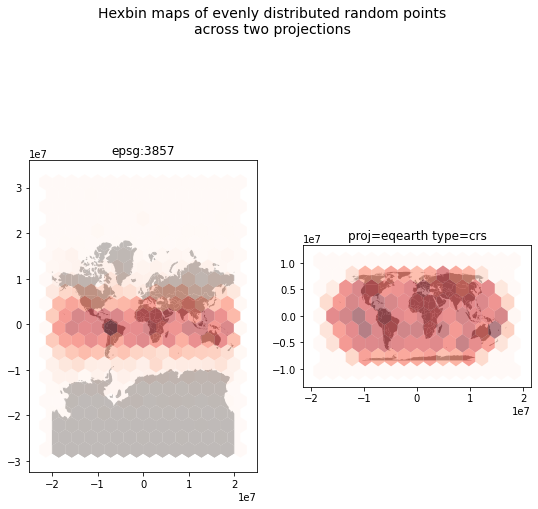

In [39]:
## Make a two panel plot for the two hexbin maps
fig = pyplot.figure(figsize=(9,9)) # you might want to change the size 
fig.suptitle("Hexbin maps of evenly distributed random points\nacross two projections", fontsize=14)

ax = fig.add_subplot(121)
ax.set_title(str(random_pts.crs))

hexbins = get_hexbin_data(random_pts, show=False)
w = geopandas.overlay(world, hexbins, 'intersection')

w.plot(ax=ax, facecolor='grey')
hexbins.plot(ax=ax, column='n', cmap="Reds", alpha=0.5)

## Equal-area hexbins in panel 2
## using equal-earth projection as suitable equal area projection 
# reproject the random points and world dataset
ax = fig.add_subplot(122)

random_pts_p=random_pts.to_crs('proj=eqearth')
world_p=world.to_crs('proj=eqearth')
ax.set_title(str(random_pts_p.crs))

# and redo the hexbin mapping
hexbins = get_hexbin_data(random_pts_p, show=False)
w = geopandas.overlay(world_p, hexbins, 'intersection')

w.plot(ax=ax, facecolor='grey')
hexbins.plot(ax=ax, column='n', cmap="Reds", alpha=0.5)


### Commentary on my answer/solution

I didn't really encounter any coding challanges. The instructions were clear and most of the code was provided anyways.

I changed the coordinate reference system (CRS) of the base map as well as of the random data set to the equal earth projection. 
This gave the best visual results in my opinion.
I actually decided to re-add Antarctica as otherwise a whole row of hex bins was hovering over empty space in the second plot. 
It just made things look a bit more consistent. 
I also decided to add more transparency to the hexbin layer (alpha=.5) so that the countries from the base map are more visible.

The two resulting hexbin maps are quite different. This is non-surprising, given that they use quite different CRSs.

The first map uses the Web (Pseudo-) Mercator projection https://en.wikipedia.org/wiki/Web_Mercator_projection#EPSG:3857.
Due to the fact that this projection inflates areas increasingly with distance from the equator, the area of the polar regions are visually vastly exaggerated.
This explains why the hexbins further away from the equator don't contain many random points and therefore mostly appear to be transparent, while hexbins closer to the equator appear in a darker red. The random points that are uniformly random distributed on a sphere are now suddenly "forced" to cover vastly different area sizes in this 2D projection and are therefore not anymore uniformly distributed in this 2D projection.

The second map solves the above shortcoming by using the equal earth projection https://en.wikipedia.org/wiki/Equal_Earth_projection.
The equal earth projection is one of many equal area projections. These are projections that retain the relative size of areas of earth when projected onto a 2D map.

The above mentioned attribute of "equiareality" of these projections leads to a plot of the random points where these appear to be uniformly random distributed in the 2D projection (and not only in the 3D space).


## Comments
Nice commentary on the projection issue. Code not difficult so no surprises there.

**A+**